In [19]:
import os
import re
import random
import string

dataset_folder_name = "asl_dataset"
dataset_directory = os.path.join(os.getcwd(), "AlphabetDataset", dataset_folder_name)
def generate_random_filename(existing_filenames, extension):
    """Generate a unique random filename."""
    while True:
        random_name = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) + extension
        if random_name not in existing_filenames:
            return random_name

def rename_images_in_folders(dataset_path):
    # Iterate through each folder inside the dataset
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        # Check if it is a directory and not a hidden/system folder
        if not os.path.isdir(folder_path) or folder.startswith("."):
            continue
        
        # List all files
        files = sorted(os.listdir(folder_path))
        existing_filenames = set()
        
        # First rename all files to random names
        temp_filenames = {}
        for file in files:
            old_file_path = os.path.join(folder_path, file)
            
            # Skip directories
            if not os.path.isfile(old_file_path):
                continue
            
            # Get file extension
            file_extension = os.path.splitext(file)[1] or ".jpeg"
            
            # Generate unique random name
            random_name = generate_random_filename(existing_filenames, file_extension)
            new_temp_path = os.path.join(folder_path, random_name)
            
            os.rename(old_file_path, new_temp_path)
            existing_filenames.add(random_name)
            temp_filenames[random_name] = file  # Keep track of renamed files
        
        # Now rename files to the correct format, starting from 1 without checking past collisions
        next_number = 1
        for temp_file in sorted(temp_filenames.keys()):
            temp_file_path = os.path.join(folder_path, temp_file)
            
            new_file_name = f"_{folder}_{next_number}.jpeg"
            new_file_path = os.path.join(folder_path, new_file_name)
            os.rename(temp_file_path, new_file_path)
            print(f"Renamed {temp_file} -> {new_file_name}")
            
            next_number += 1  # Increment for next file
        
        print(f"Renaming completed for folder: {folder}")

# Automatically detect dataset directory path based on current working directory

rename_images_in_folders(dataset_directory)

print("Renaming complete!")


Renamed 0TtM72Pg.jpeg -> _0_1.jpeg
Renamed 0g7TBSW1.jpeg -> _0_2.jpeg
Renamed 2EeiiDbr.jpeg -> _0_3.jpeg
Renamed 2RzFW1xn.jpeg -> _0_4.jpeg
Renamed 2voeOcWp.jpeg -> _0_5.jpeg
Renamed 3IQR9O4d.jpeg -> _0_6.jpeg
Renamed 43Td4QyB.jpeg -> _0_7.jpeg
Renamed 4Ly1dSuB.jpeg -> _0_8.jpeg
Renamed 4REyOnxr.jpeg -> _0_9.jpeg
Renamed 4U7XY8vn.jpeg -> _0_10.jpeg
Renamed 4dF4HqIF.jpeg -> _0_11.jpeg
Renamed 4u6bqG7b.jpeg -> _0_12.jpeg
Renamed 5ZUUCrR0.jpeg -> _0_13.jpeg
Renamed 6BPDf61x.jpeg -> _0_14.jpeg
Renamed 89s7ecbJ.jpeg -> _0_15.jpeg
Renamed 9rHxGSfL.jpeg -> _0_16.jpeg
Renamed ApOCfrrb.jpeg -> _0_17.jpeg
Renamed BKdmGETj.jpeg -> _0_18.jpeg
Renamed BflBmmiY.jpeg -> _0_19.jpeg
Renamed C5BLFOXc.jpeg -> _0_20.jpeg
Renamed CyGrU4XO.jpeg -> _0_21.jpeg
Renamed DcYUx3T3.jpeg -> _0_22.jpeg
Renamed EAbhDjdB.jpeg -> _0_23.jpeg
Renamed GLQIpYr2.jpeg -> _0_24.jpeg
Renamed GRprhFSp.jpeg -> _0_25.jpeg
Renamed Gm2cIS6W.jpeg -> _0_26.jpeg
Renamed IxLXrRb3.jpeg -> _0_27.jpeg
Renamed Lc8R2cub.jpeg -> _0_28.jpeg
R

In [20]:
import cv2
import mediapipe as mp
import numpy as np
import os
import joblib
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Paths
DATASET_PATH = dataset_directory

# Verify if the dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

LABELS = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Function to extract label from filename
def extract_label_from_filename(filename):
    match = re.search(r'_([a-z0-9])_', filename)
    return match.group(1) if match else None

# Function to extract hand landmarks
def extract_landmarks(image_path):
    if not os.path.isfile(image_path):
        return None  # Ensure we only process files
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load image {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

        # Extract relative path
        relative_path = os.path.relpath(image_path, DATASET_PATH)
        print(f"Successfully extracted landmarks from: {relative_path}")  # Debugging output
        return landmarks
    return None

# Prepare dataset
X, y = [], []
Label_List = []
Label_Count = []
Label_FailCount = []
for label in LABELS:
    Label_List.append(label)
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        failCount = 0
        count = 0
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            if not os.path.isfile(img_path):
                continue  # Skip directories
            extracted_label = extract_label_from_filename(img_file)
            if extracted_label:
                landmarks = extract_landmarks(img_path)
                if landmarks:
                    X.append(landmarks)
                    y.append(extracted_label)
                    count = count + 1
                    # Extract relative path
                    relative_path = os.path.relpath(img_path, DATASET_PATH)
                    print(f"File used for training: {relative_path} - Label: {extracted_label}")  # Debugging output
                else:
                    failCount = failCount + 1
        Label_Count.append(count)
        Label_FailCount.append(failCount)


Successfully extracted landmarks from: 0\_0_16.jpeg
File used for training: 0\_0_16.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_19.jpeg
File used for training: 0\_0_19.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_2.jpeg
File used for training: 0\_0_2.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_20.jpeg
File used for training: 0\_0_20.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_21.jpeg
File used for training: 0\_0_21.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_22.jpeg
File used for training: 0\_0_22.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_24.jpeg
File used for training: 0\_0_24.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_27.jpeg
File used for training: 0\_0_27.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_29.jpeg
File used for training: 0\_0_29.jpeg - Label: 0
Successfully extracted landmarks from: 0\_0_31.jpeg
File used for training: 0\_0_31.jpeg - Label: 0
Su

In [21]:
for i in range(0, len(Label_Count)):
    print(f"Label{Label_List[i]}:  LandMarkSuccess = {Label_Count[i]}, LandMarkFail = {Label_FailCount[i]}")

Label0:  LandMarkSuccess = 29, LandMarkFail = 41
Label1:  LandMarkSuccess = 60, LandMarkFail = 10
Label2:  LandMarkSuccess = 49, LandMarkFail = 21
Label3:  LandMarkSuccess = 68, LandMarkFail = 2
Label4:  LandMarkSuccess = 69, LandMarkFail = 1
Label5:  LandMarkSuccess = 70, LandMarkFail = 0
Label6:  LandMarkSuccess = 51, LandMarkFail = 19
Label7:  LandMarkSuccess = 65, LandMarkFail = 5
Label8:  LandMarkSuccess = 61, LandMarkFail = 9
Label9:  LandMarkSuccess = 70, LandMarkFail = 0
Labela:  LandMarkSuccess = 15, LandMarkFail = 55
Labelb:  LandMarkSuccess = 65, LandMarkFail = 5
Labelc:  LandMarkSuccess = 33, LandMarkFail = 37
Labeld:  LandMarkSuccess = 66, LandMarkFail = 4
Labele:  LandMarkSuccess = 22, LandMarkFail = 48
Labelf:  LandMarkSuccess = 68, LandMarkFail = 2
Labelg:  LandMarkSuccess = 53, LandMarkFail = 17
Labelh:  LandMarkSuccess = 46, LandMarkFail = 24
Labeli:  LandMarkSuccess = 53, LandMarkFail = 17
Labelj:  LandMarkSuccess = 13, LandMarkFail = 57
Labelk:  LandMarkSuccess = 67

In [22]:

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Ensure dataset is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid hand landmarks found in dataset. Check dataset structure.")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, 'asl_rf_model.pkl')
print("Model saved as asl_rf_model.pkl")

# Evaluate Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')


Model saved as asl_rf_model.pkl
Model Accuracy: 0.94


✅ Model file found. Loading...


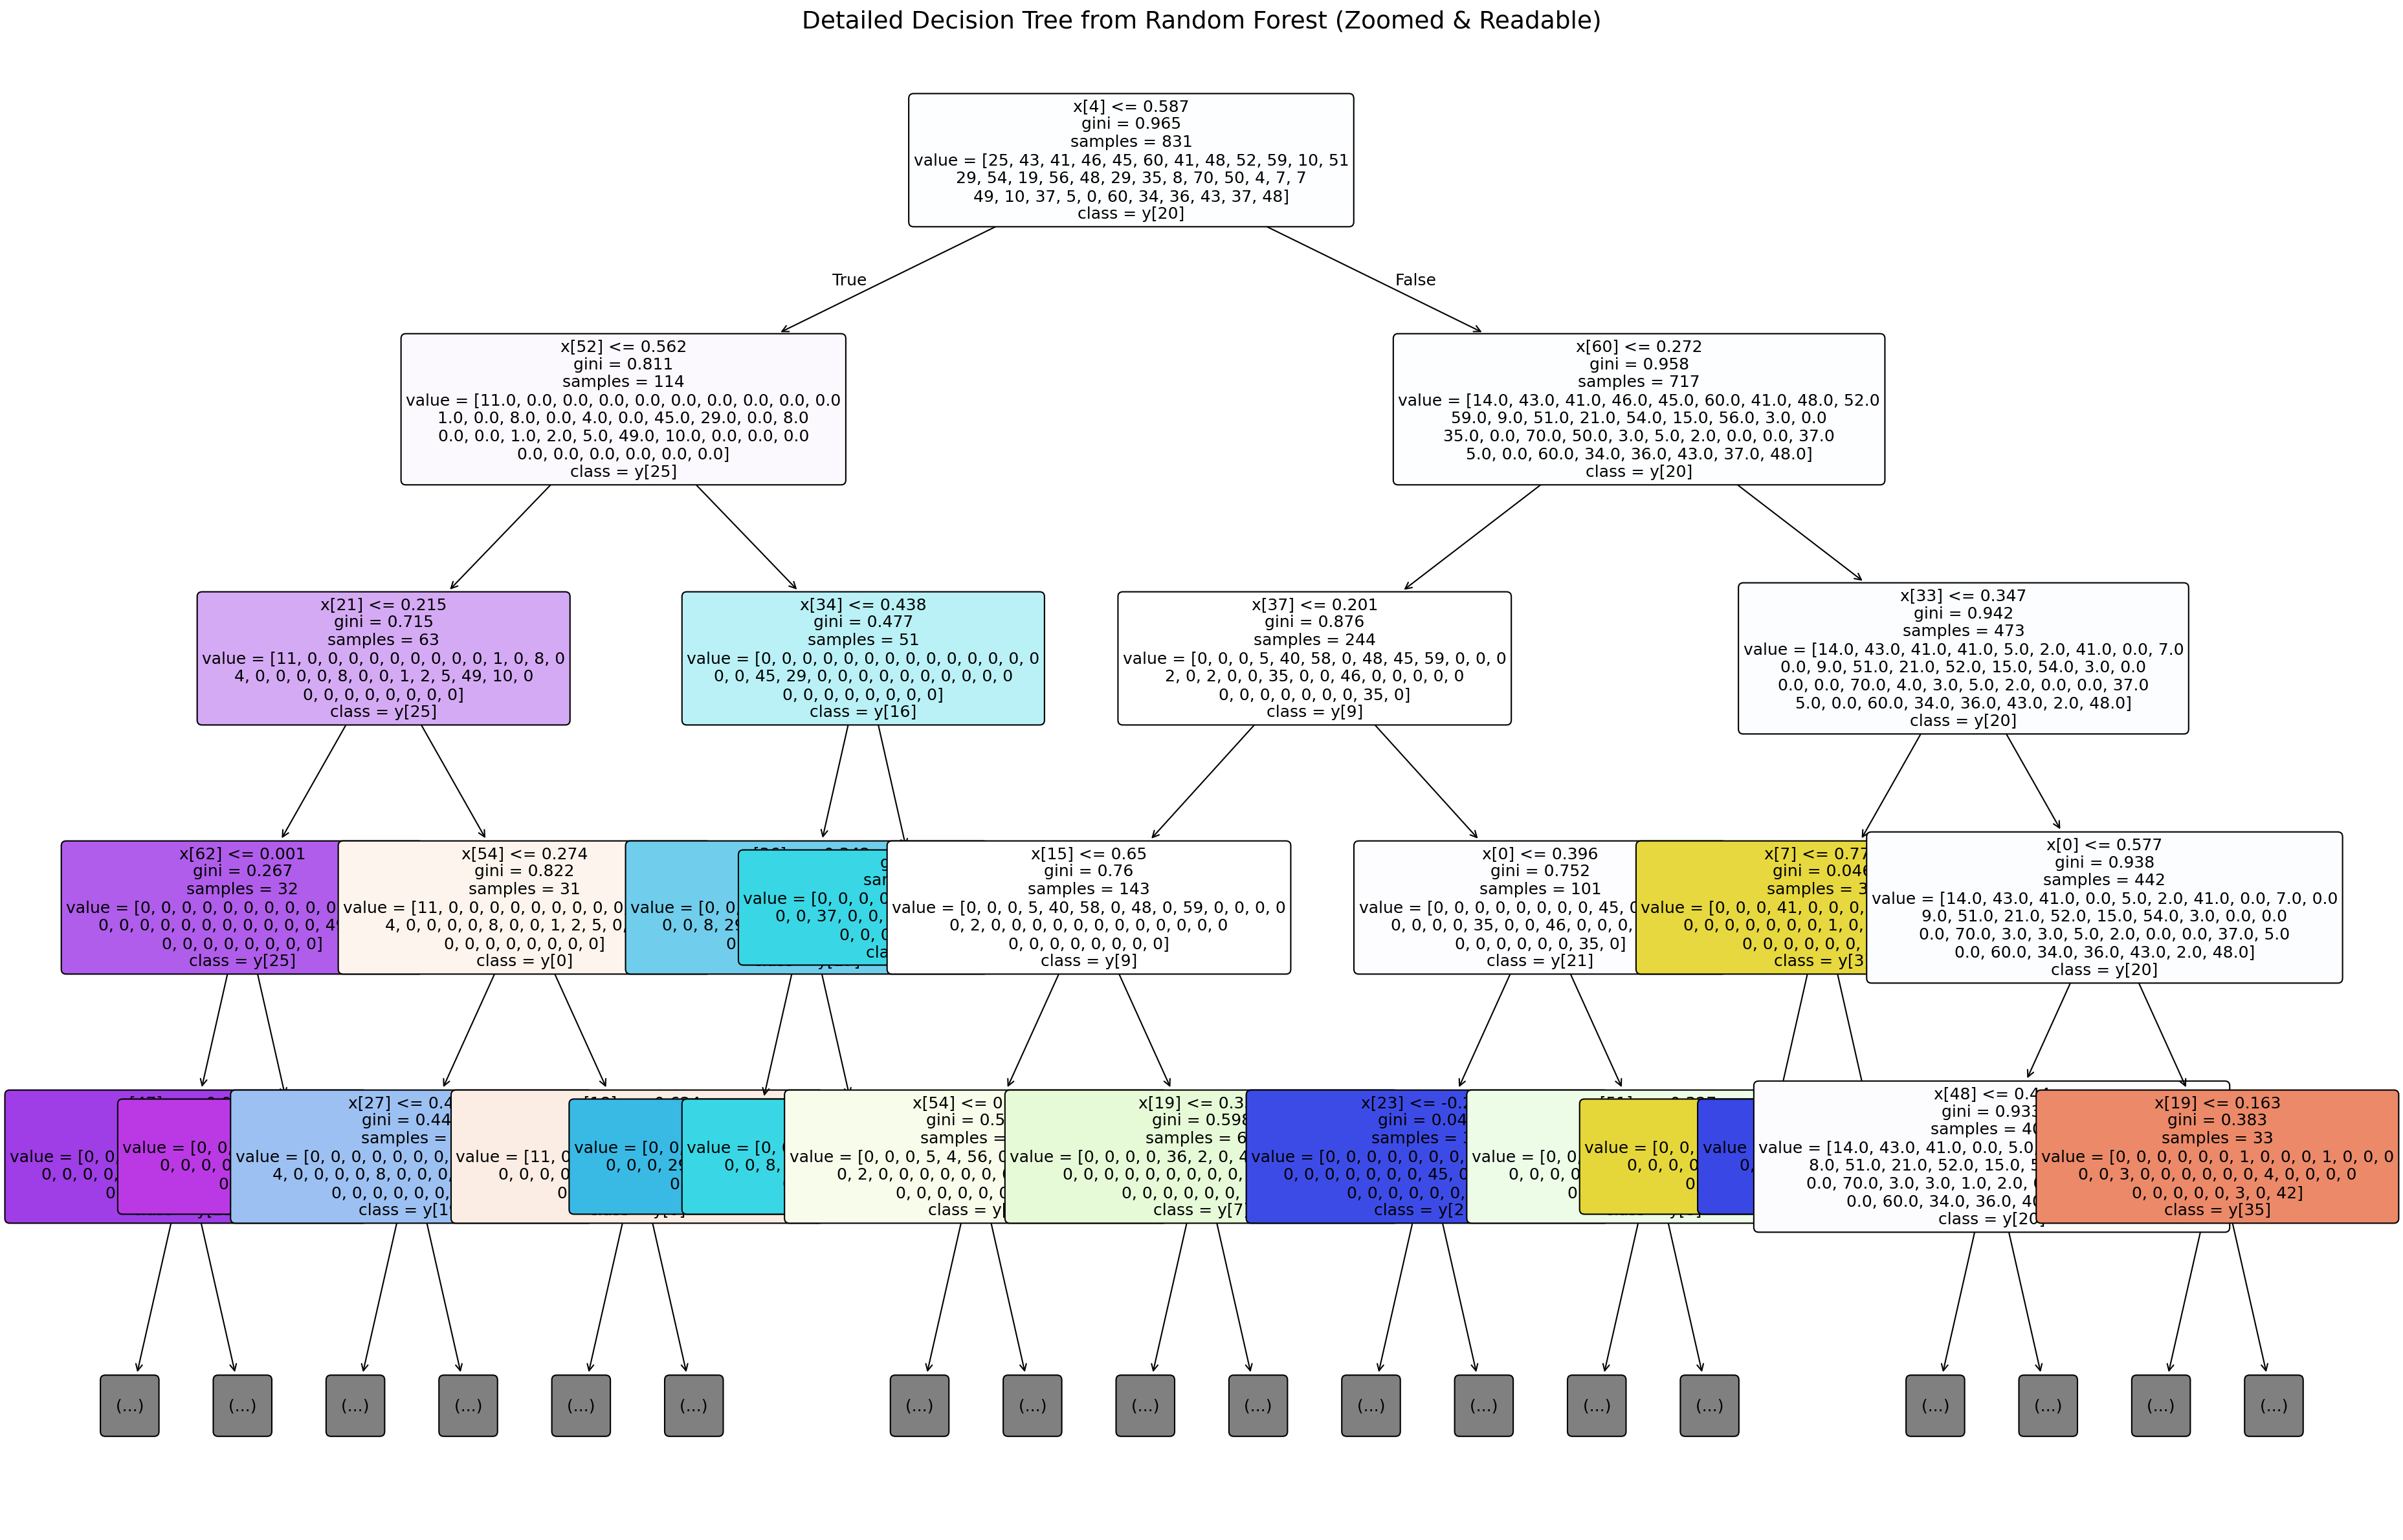

In [23]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define model path
model_path = os.path.join(os.getcwd(), "asl_rf_model.pkl")
# Check if model exists
if os.path.exists(model_path):
    print("✅ Model file found. Loading...")
else:
    print("❌ Model file NOT found. Check the file path!")
    exit()

# Load the trained Random Forest model
clf = joblib.load(model_path)

# Select a single decision tree from the Random Forest
tree = clf.estimators_[0]  # First tree in the forest

# Generate a large and detailed decision tree visualization
plt.figure(figsize=(30, 20), dpi=150)  # Increased figure size

plot_tree(
    tree, 
    filled=True, 
    feature_names=None,  # Replace with actual feature names if available
    class_names=True, 
    rounded=True, 
    fontsize=12,  # Larger font size for readability
    max_depth=4  # Limit depth to keep it readable (adjustable)
)

plt.title("Detailed Decision Tree from Random Forest (Zoomed & Readable)", fontsize=18)
plt.show()


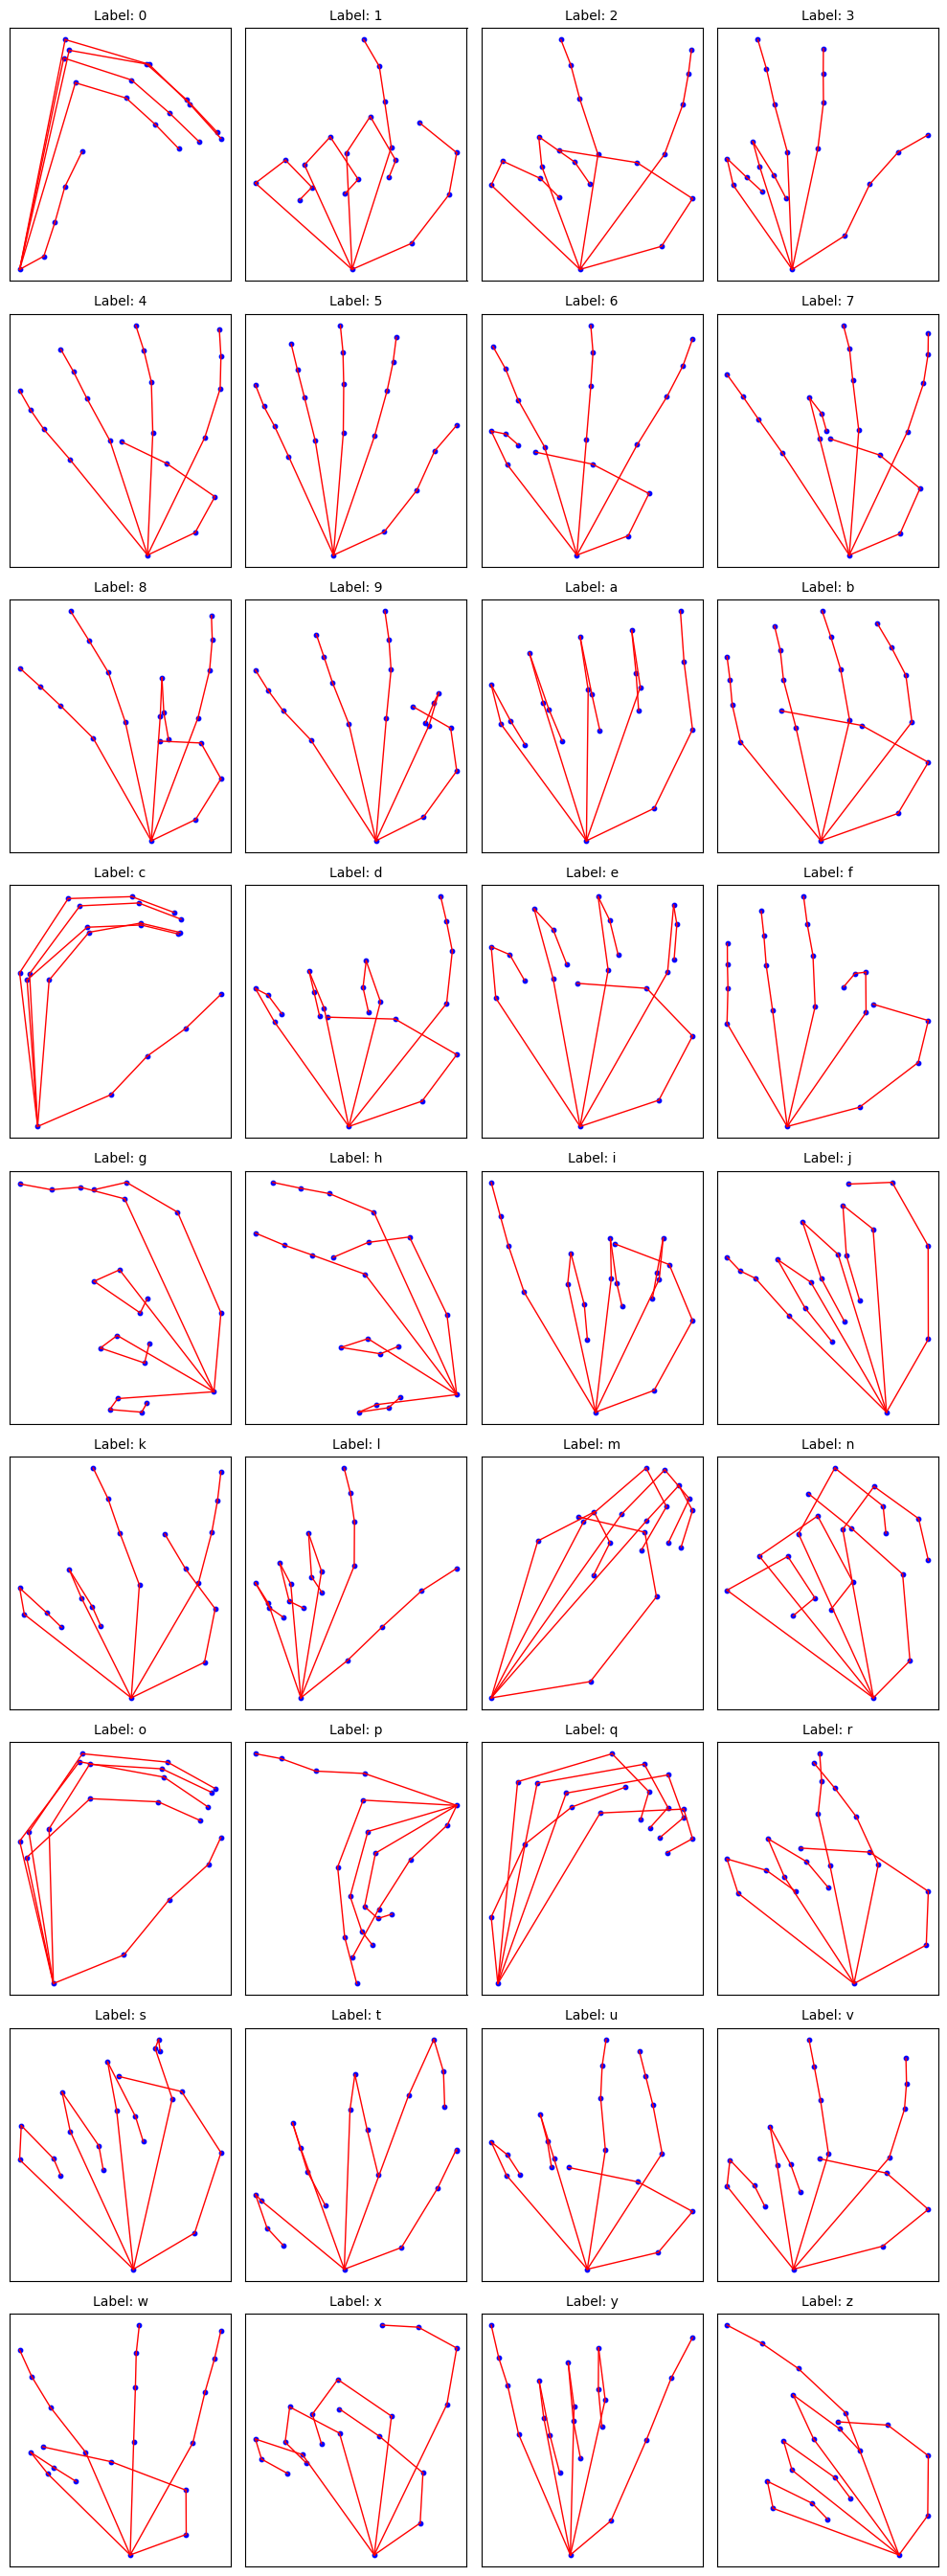

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to extract and store landmarks as numerical values

def extract_landmark_values(landmarks, label):
    if landmarks is None:
        return None
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    # Store landmarks as a list of dictionaries
    landmark_data = {
        "label": label,
        "landmarks": [{"x": lm[0], "y": lm[1], "z": lm[2]} for lm in landmarks],
        "connections": [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                        (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky
    }
    
    return landmark_data

# Function to visualize landmarks
def plot_landmarks(ax, landmarks, label):
    if landmarks is None:
        ax.set_title(f"No landmarks for {label}")
        ax.axis("off")
        return
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    ax.scatter(landmarks[:, 0], -landmarks[:, 1], c='blue', s=10)  # Smaller points
    
    # Define connections based on MediaPipe hand structure
    connections = [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                   (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                   (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                   (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                   (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky

    for start, end in connections:
        ax.plot([landmarks[start, 0], landmarks[end, 0]],
                 [-landmarks[start, 1], -landmarks[end, 1]], 'r-', linewidth=1)

    ax.set_title(f"Label: {label}", fontsize=10)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Store landmark data for each label
landmark_data_list = []

unique_labels = sorted(set(y))  # Extract unique labels from dataset

num_labels = len(unique_labels)
num_cols = 4  # 4 plots per row
num_rows = max(1, (num_labels + num_cols - 1) // num_cols)  # Ensure at least 1 row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    idxs = np.where(y == label)[0]
    if len(idxs) == 0:
        continue  # Skip if no landmarks for this label
    idx = idxs[0]  # Get first occurrence of label
    
    # Extract numerical values
    landmark_values = extract_landmark_values(X[idx], label)
    if landmark_values:
        landmark_data_list.append(landmark_values)
    
    # Plot visualization
    plot_landmarks(axes[i], X[idx], label)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()





In [25]:
# Save landmarks as JSON file
with open('hand_landmarks_data.json', 'w') as json_file:
    json.dump(landmark_data_list, json_file, indent=4)

print("\n✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.\n")

# Optional: Display numerical values in a readable format
for idx, data in enumerate(landmark_data_list):
    print("=" * 40)
    print(f"📌 Label: {data['label']}")
    print(f"🖐 Total Landmarks: {len(data['landmarks'])}")
    print("=" * 40)

    # Print landmark coordinates in a structured way
    print(f"{'Index':<6} {'X':<10} {'Y':<10} {'Z':<10}")
    print("-" * 40)
    for i, lm in enumerate(data["landmarks"]):
        print(f"{i:<6} {lm['x']:<10.5f} {lm['y']:<10.5f} {lm['z']:<10.5f}")

    print("\n🔗 Connections:")
    for conn in data["connections"]:
        print(f"({conn[0]} → {conn[1]})", end="  ")
    
    print("\n" + "=" * 40 + "\n")




✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.

📌 Label: 0
🖐 Total Landmarks: 21
Index  X          Y          Z         
----------------------------------------
0      0.27319    0.39018    0.00000   
1      0.33143    0.37007    -0.06567  
2      0.35817    0.31829    -0.12136  
3      0.38203    0.26428    -0.16871  
4      0.42327    0.21075    -0.21352  
5      0.37943    0.06787    -0.10405  
6      0.54247    0.10133    -0.16829  
7      0.63471    0.15216    -0.22000  
8      0.70594    0.19577    -0.25485  
9      0.38280    0.03975    -0.10213  
10     0.58460    0.07740    -0.15793  
11     0.68277    0.13789    -0.19022  
12     0.75797    0.19065    -0.21170  
13     0.39263    0.05605    -0.10484  
14     0.57894    0.07702    -0.16174  
15     0.67597    0.13183    -0.18099  
16     0.74968    0.18144    -0.18954  
17     0.40745    0.10560    -0.11214  
18     0.52983    0.12894    -0.15644  
19     0.60014    0.16935    -0.16534  
20     0.65

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import joblib

# Load Model
model_name = "asl_rf_model.pkl"
model_directory = os.path.join(os.getcwd(),  model_name)
clf = joblib.load(model_directory)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles  # For better visualization
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract hand landmarks from webcam frame
def extract_landmarks_from_frame(frame, results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return np.array(landmarks).reshape(1, -1)  # Return the reshaped array
    return None

# Start Webcam Capture
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Extract landmarks and predict
    landmarks = extract_landmarks_from_frame(frame, results)
    if landmarks is not None:
        prediction = clf.predict(landmarks)[0]
        cv2.putText(frame, f'Predicted: {prediction.upper()}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

    # Show the output frame
    cv2.imshow('ASL Detection', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
